# Reading PDF Documents in Python

In this notebook we will introduce the concepts of opening and reading PDF documents using the Python library PyMuPDF. This library can extract text, images and tables from digital PDFs. However, from print PDFs, such as scanned PDFs or PDFs which have vector graphics in them (most Powerpoint presentations), this library capabilities is limited.


### Python Imports


In [5]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('..\\code')


import os
from dotenv import load_dotenv
load_dotenv()

from IPython.display import display, Markdown, HTML
from PIL import Image
from doc_utils import *


def show_img(img_path, width = None):
    if width is not None:
        display(HTML(f'<img src="{img_path}" width={width}>'))
    else:
        display(Image.open(img_path))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Make sure we have the OpenAI Models information

We will need the GPT-4-Turbo and GPT-4-Vision models for this notebook.

When running the below cell, the values should reflect the OpenAI reource you have created in 

In [ ]:
model_info = {
        'AZURE_OPENAI_RESOURCE': os.environ.get('AZURE_OPENAI_RESOURCE'),
        'AZURE_OPENAI_KEY': os.environ.get('AZURE_OPENAI_KEY'),
        'AZURE_OPENAI_MODEL_VISION': os.environ.get('AZURE_OPENAI_MODEL_VISION'),
        'AZURE_OPENAI_MODEL': os.environ.get('AZURE_OPENAI_MODEL'),
}

model_info


## Read a Digital PDF Document

Open a digital PDF Document with PyMuPDF, and save its pages as high-resolution PNG files. 



In [7]:
import fitz  # PyMuPDF

# Create a directory to store the outputs
work_dir = "sample_data/pdf_outputs"
os.makedirs(work_dir, exist_ok=True)

# Load a sample PDF document

def read_pdf(pdf_doc):
    doc = fitz.open(pdf_doc)
    print(f"PDF File {os.path.basename(pdf_doc)} has {len(doc)} pages.")
    return doc

pdf_doc = "sample_data/1_London_Brochure.pdf"
doc = read_pdf(pdf_doc)

PDF File 1_London_Brochure.pdf has 2 pages.


#### Extract Pages as PNG Files

Extract the pages and store them as a PNG file. Please check them the output in the directory `work_dir`.

In [8]:
def nb_extract_pages_as_png_files(doc):
    png_files = []
    for page in doc:
        page_num = page.number
        img_path = f"{work_dir}/page_{page_num}.png"
        page_pix = page.get_pixmap(dpi=300)
        page_pix.save(img_path)
        print(f"Page {page_num} saved as {img_path}")
        png_files.append(img_path)
    return png_files

nb_extract_pages_as_png_files(doc)        


Page 0 saved as sample_data/pdf_outputs/page_0.png
Page 1 saved as sample_data/pdf_outputs/page_1.png


##### Show Extracted Images

In [9]:
show_img('sample_data/pdf_outputs/page_0.png', width=300)
show_img('sample_data/pdf_outputs/page_1.png', width=300)

#### Extract Text

Extract text from the pages and store them as text files. Please check them the output in the directory `work_dir`.

In [10]:
def nb_extract_text(doc):
    txt_files = []

    for page in doc:
        page_num = page.number
        text = page.get_text()

        text_filename = os.path.join(work_dir, f"page_{page_num}.txt")
        txt_files.append(text_filename)
        with open(text_filename, 'w', encoding='utf-8') as file:
            file.write(text)

        print(f"Page {page_num} text saved to {text_filename}")

    print(f"\n\nSnippet from First Page Text:\n\n{read_asset_file(txt_files[0])[0]}")

    return txt_files

txt_files = nb_extract_text(doc)

Page 0 text saved to sample_data/pdf_outputs\page_0.txt
Page 1 text saved to sample_data/pdf_outputs\page_1.txt


Snippet from First Page Text:

Margie’s Travel Presents… 
London 
London is the capital and 
most populous city of 
England and the United 
Kingdom. Standing on the 
River Thames in the south 
east of the island of Great 
Britain, London has been 
a major settlement for two 
millennia. It was founded 
by the Romans, who 
named it Londinium. 
London's ancient core, the 
City of London, largely 
retains its 1.12-square- 
mile medieval boundaries. 
Since at least the 19th century, London has also referred to the metropolis around this core, 
historically split between Middlesex, Essex, Surrey, Kent, and Hertfordshire, which today largely 
makes up Greater London, governed by the Mayor of London and the London Assembly. 
 
 
Mostly popular for: 
Leisure, Outdoors, Historical, Arts 
& Culture 
Best time to visit: 
Jun-Aug 
Averag Precipitation: 1.9 in 
Average Temperature: 56-67

#### Post-Process the Text

Post-process the extracted text from the PDF using GPT-4. This will help to clean up the text and make it more readable, as well as enhance accuracy of search and RAG.

In [11]:
process_extracted_text_prompt = """
The Extracted Text below is extracted with OCR, and might have tables in them. The number of tables is unknown. Please reformat all text and re-arrange it. Do not add text from your side, use the Extracted Text verbatim word-for-word. If you detect tables in the Extracted Text, please output them in Markdown format. The objective here to make the Extracted Text more readable and understandable. Do **NOT** any comments, details, explanations or justifications from your part.

Extracted Text:
## START OF EXTRACTED TEXT
{text}
## END OF EXTRACTED TEXT

If a table is present in the text, a Markdown version of the table might be available below. Use it as your guidance to reconstruct the "Extracted Text":
{markdown}


"""

def nb_post_process_text(text_file):
    p = process_extracted_text_prompt.format(text=read_asset_file(text_file)[0], markdown = "No Markdown Table Available")

    output = ask_LLM(p, model_info=model_info)
    print(output)

nb_post_process_text(txt_files[0])

## Margie’s Travel Presents: London

London is the capital and most populous city of England and the United Kingdom. Standing on the River Thames in the southeast of the island of Great Britain, London has been a major settlement for two millennia. It was founded by the Romans, who named it Londinium. London's ancient core, the City of London, largely retains its 1.12-square-mile medieval boundaries. Since at least the 19th century, London has also referred to the metropolis around this core, historically split between Middlesex, Essex, Surrey, Kent, and Hertfordshire, which today largely makes up Greater London, governed by the Mayor of London and the London Assembly.

### Mostly popular for:
- Leisure
- Outdoors
- Historical
- Arts & Culture

### Best time to visit:
Jun-Aug

### Average Precipitation:
1.9 in

### Average Temperature:
56-67°F

### London Hotels
Margie’s Travel offers the following accommodation options in London:

- **The Buckingham Hotel**
  Comfortable hotel close t

#### Extract Embedded Images

In PDF files, one can find images embedded in pages. Below, we extract these images and save them. Please check them the output in the directory `work_dir`.

In [12]:
def nb_extract_images(doc):
    for page in doc:
        for img_index, img in enumerate(page.get_images()):
            page_number = page.number
            xref = img[0]
            base_image = doc.extract_image(xref)
            pix = fitz.Pixmap(doc, xref)
            pix = fitz.Pixmap(fitz.csRGB, pix)                
            image_filename = os.path.join(work_dir, f'page_{page_number}_image_{img_index+1}.png')
            pix.save(image_filename, 'PNG')
            print(f"Image found in page {page_number} saved as {image_filename}")

nb_extract_images(doc)            

Image found in page 0 saved as sample_data/pdf_outputs\page_0_image_1.png
Image found in page 0 saved as sample_data/pdf_outputs\page_0_image_2.png


In [13]:
show_img('sample_data/pdf_outputs/page_0_image_1.png', width=500)

#### Extract Tables

In PDF files, one can find embedded tables. Below, we extract those tables using PyMuPDF. 

In [14]:
def nb_extract_tables(doc):
    for page in doc:
        tables = page.find_tables()
        page_number = page.number

        for table in tables:
            df = table.to_pandas()
            print(f"{len(df)} table(s) on {page_number}")
            display(df.head())

nb_extract_tables(doc)        

5 table(s) on 1


,Category,Information
0,Country,United Kingdom
1,Capital Of,England
2,Currency,Pound Sterling (GBP)
3,Population (2021 census),Approximately 8.8 million
4,Famous For,"Historical landmarks, museums, cultural diversity"


## Read a Non-Digital PDF Document

Open a non-digital PDF Document with PyMuPDF, like a scanned print PDF or a Powerpoint presentation with lots of vector graphics, and try to extract text, images and tables.



In [15]:
import fitz  # PyMuPDF

# Create a directory to store the outputs
work_dir = "sample_data/pdf_outputs_print"
os.makedirs(work_dir, exist_ok=True)

# Load a sample PDF document

def read_pdf(pdf_doc):
    doc = fitz.open(pdf_doc)
    print(f"PDF File {os.path.basename(pdf_doc)} has {len(doc)} pages.")
    return doc

pdf_doc = "sample_data/1_slide_1.pdf"
doc = read_pdf(pdf_doc)

PDF File 1_slide_1.pdf has 1 pages.


In [16]:
nb_extract_text(doc)

Page 0 text saved to sample_data/pdf_outputs_print\page_0.txt


Snippet from First Page Text:

Infrastructure is forecasted to be one of the fastest-growing 
segments of private markets
4
729
1,190
2,541
2017
2022
2027
Energy
Telecom 
& digital
Transport
Water
23
7
40
5
Investment
Needs
2022-2040 cumulative infrastructure investment & needs, $T
16% 
CAGR
Note: For footnoted information, refer to slide 11.
10% 
CAGR
Industry infrastructure AUM1
$75T global infrastructure funding need2
Clients allocating more to infra in new market regime3
Infrastructure fares well in inflationary environments4
43%
37%
28%
22%
22%
18%
39%
45%
57%
50%
43%
52%
18%
18%
15%
28%
35%
30%
Private Debt
Infrastructure
Private Equity
Hedge Funds
Venture Capital
Real Estate
More capital
Same amount of capital
Less capital
Global Direct 
Infrastructure
Global Direct 
Real Estate
Global Equities
Global Fixed 
Income
17%
16%
15%
0%
Global Direct 
Infrastructure
Global Direct 
Real Estate
Global Equities
Global Fixed 


['sample_data/pdf_outputs_print\\page_0.txt']

In [17]:
nb_post_process_text('sample_data/pdf_outputs_print/page_0.txt')

Infrastructure is forecasted to be one of the fastest-growing segments of private markets.

Investment Needs:
2022-2040 cumulative infrastructure investment & needs, $T
- Energy: 23
- Telecom & digital: 7
- Transport: 40
- Water: 5

Industry infrastructure AUM1:
- 2017: 729
- 2022: 1,190
- 2027: 2,541

$75T global infrastructure funding need2

Clients allocating more to infra in new market regime3:
- 16% CAGR
- Infrastructure fares well in inflationary environments4

Allocation of Capital by Clients:
- More capital: Private Debt (43%), Infrastructure (37%), Private Equity (28%), Hedge Funds (22%), Venture Capital (22%), Real Estate (18%)
- Same amount of capital: Private Debt (39%), Infrastructure (45%), Private Equity (57%), Hedge Funds (50%), Venture Capital (43%), Real Estate (52%)
- Less capital: Private Debt (18%), Infrastructure (18%), Private Equity (15%), Hedge Funds (28%), Venture Capital (35%), Real Estate (30%)

20-year total returns (ann’d) in different market conditions:
-

Image found in page 0 saved as sample_data/pdf_outputs_print\page_0_image_1.png


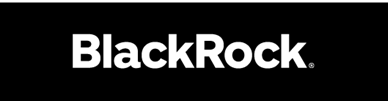

In [18]:
nb_extract_images(doc)
show_img('sample_data/pdf_outputs_print\page_0_image_1.png')

In [19]:
nb_extract_tables(doc)

1 table(s) on 0


,"Infrastructure is forecasted to be one of the fastest-growing\nsegments of private markets\nIndustry infrastructure AUM1 $75T global infrastructure funding need2\n2022-2040 cumulative infrastructure investment & needs, $T\nInvestment 40\n16%\nCAGR 2,541 Needs\n10%\n23\nCAGR\n1,190\n729\n7\n5\n2017 2022 2027 Energy Telecom Transport Water\n& digital\nClients allocating more to infra in new market regime3 Infrastructure fares well in inflationary environments4\nHigh growth / high inflation\nPrivate Debt 43% 39% 18%\n17% 16% 15% (ann’d)\nInfrastructure 37% 45% 18%\n0%\nPrivate Equity 28% 57% 15% returns\nGlobal Direct Global Direct Global Equities Global Fixed\nInfrastructure Real Estate Income\nHedge Funds 22% 50% 28%\ntotal\nLow growth / high inflation\nVenture Capital 22% 43% 35% 23%\n20-year\nReal Estate 18% 52% 30% 8% 8%\n2%\nMore capital Same amount of capital Less capital\nGlobal Direct Global Direct Global Equities Global Fixed\nInfrastructure Real Estate Income\nNote: For footnoted information, refer to slide 11."
0,4


1 table(s) on 0


,"16%\nCAGR 2,541\n10%\nCAGR\n1,190\n729"
0,


4 table(s) on 0


,"16%\nCAGR 2,5\n10%\nCAGR",Col1,Col2,Col3
0,None,10%\nCAGR,None,None
1,None,None,None,
2,None,,"1,190",None
3,None,None,,None


1 table(s) on 0


,Col0
0,


1 table(s) on 0


,Col0
0,


6 table(s) on 0


,43% 39% 18%,Col1,Col2,Col3,Col4
0,37%,None,45%,None,18%
1,,None,None,None,None
2,28% 57% 15%,None,None,None,None
3,22% 50% 28%,None,None,None,None
4,22% 43% 35%,None,None,None,None


0 table(s) on 0


,Col0,Col1


0 table(s) on 0


,Col0,2%,Col2


### Exercise

Try reading the file `1_slide_2.pdf` and extract the text, images and tables from it.